In [198]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import scipy.stats as stats
import matplotlib.colors as colors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopy.distance
import random
%matplotlib inline
%config InlineBackend.figure_format='retina'



In [25]:
ds = xr.open_dataset("ERA5_CF_202001.nc")
print(ds)

<xarray.Dataset>
Dimensions:     (latitude: 201, longitude: 445, time: 744)
Coordinates:
  * longitude   (longitude) float32 -31.0 -30.75 -30.5 ... 79.5 79.75 80.0
  * latitude    (latitude) float32 80.0 79.75 79.5 79.25 ... 30.5 30.25 30.0
  * time        (time) datetime64[ns] 2020-01-01 ... 2020-01-31T23:00:00
Data variables:
    solarCF     (time, latitude, longitude) float32 ...
    windCF_off  (time, latitude, longitude) float32 ...
    windCF_on   (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2021-12-24 19:52:30 GMT by grib_to_netcdf-2.23.0: /opt/ecmw...
    author:       Laurens Stoop UU/KNMI/TenneT
    created:      27-01-2022
    map_area:     Europe
    data_source:  ERA5 reanalysis data, contains modified Copernicus Climate ...


In [210]:
latitudes = ds['latitude'].values
longitudes = ds['longitude'].values
print("Possible (lat, lon) combinations:")
lat_min, lat_max = latitudes.min(), latitudes.max()
lon_min, lon_max = longitudes.min(), longitudes.max()

print(f"Minimum latitude: {lat_min}")
print(f"Maximum latitude: {lat_max}")
print(f"Minimum longitude: {lon_min}")
print(f"Maximum longitude: {lon_max}")



Possible (lat, lon) combinations:
Minimum latitude: 30.0
Maximum latitude: 80.0
Minimum longitude: -31.0
Maximum longitude: 80.0


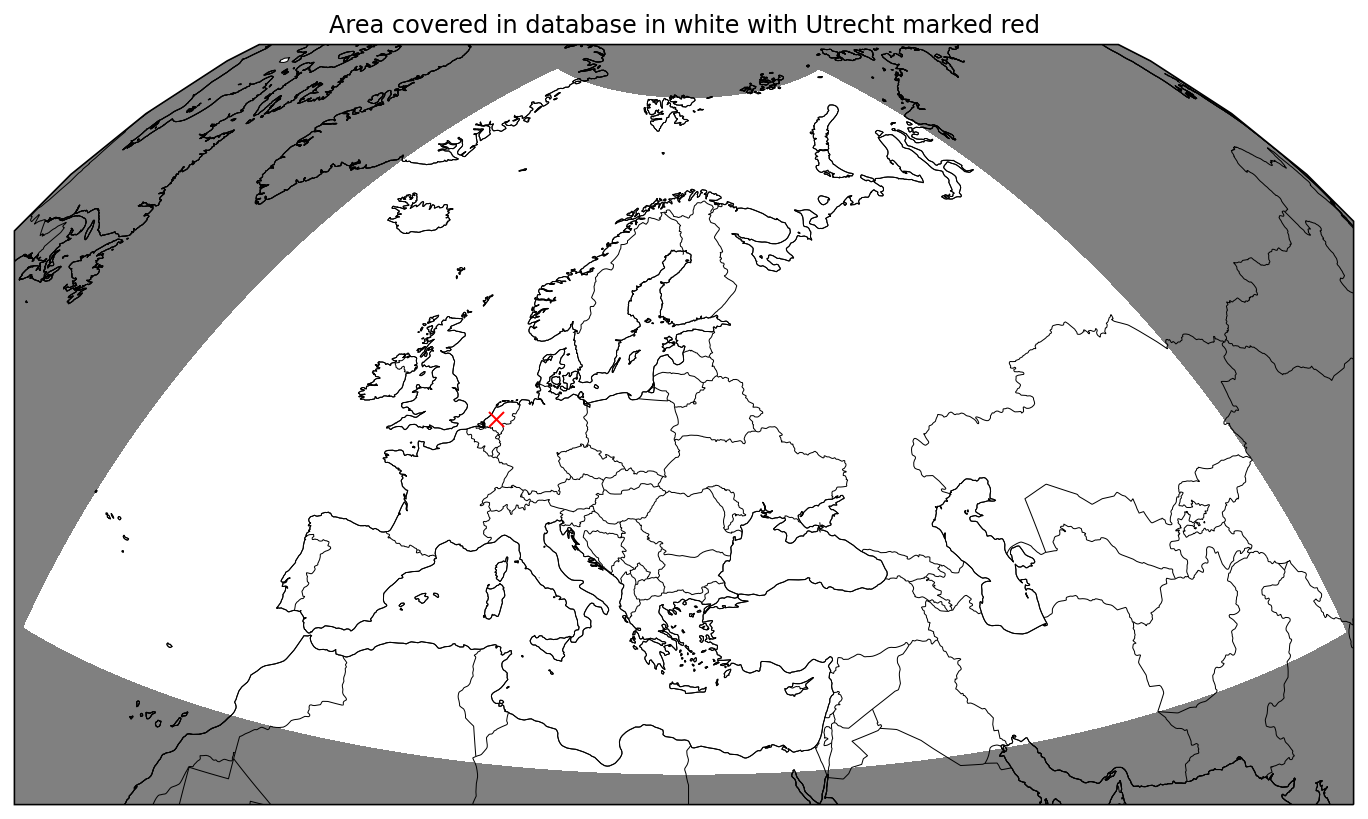

In [258]:

utrecht= (52.0907, 5.1214)

import colorsys


def rnd_dark():
    r = random.randint(0, 255)
    g = random.randint(0, 255)
    b = random.randint(0, 255)
    # Return the color as an RGB tuple
    return (r/255, g/255, b/255)

#lat_min +=5
#lat_max -= 5
#lon_min += 5
#lon_max -=5

edges = [(lat_min+5, lon_min+5), (lat_max-5, lon_min+5), (lat_max-5, lon_max-5), (lat_min+5, lon_max-5)]
def gridPlot(origincell,samplelist):
    centerlat = (lat_min + lat_max) / 2
    centerlon = (lon_min + lon_max) / 2

    # the coordinates of utrecht
    lat_utrecht, lon_utrecht = 52.0907, 5.1214

    #Plot the data map
    solarCF = ds.solarCF
    time_idx = 0
    #p1 = solarCF.isel(time=time_idx).plot(
    #    subplot_kws=dict(projection=ccrs.Orthographic(centerlat-30, centerlon ), facecolor="gray"),
    #    transform=ccrs.PlateCarree(),
    #)
    p = solarCF.isel(time=time_idx).plot(
        transform=ccrs.PlateCarree(),
        subplot_kws={"projection": ccrs.Orthographic(centerlat-30, centerlon), "extent": (lon_min+5, lon_max-5, lat_min-10, lat_max+5)},
        cmap=colors.ListedColormap(['white']),
        #facecolor="gray",
        add_colorbar=False,
    )

    ax = plt.gca()
    #ax.set_extent([-180, 180, 0, 90], crs=ccrs.PlateCarree()) #northern hem. only
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5)
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), edgecolor='black', linewidth=0.5)
    ax.add_feature(cfeature.BORDERS.with_scale('50m'), edgecolor='black', linewidth=0.5)

    ax.add_feature(cfeature.LAND.with_scale('50m'), linewidth=0.5, facecolor='gray', edgecolor='black', zorder=0)
    ax.add_feature(cfeature.OCEAN.with_scale('50m'), linewidth=0.5, facecolor='gray', edgecolor='black', zorder=0)



    #Add marker for all cells in ds
    #for lat in ds.latitude.values[100:110]:
    #    for lon in ds.longitude.values[250:355]:
    #        ax.plot(lon, lat, marker='o', color='black', markersize=0.05, alpha=1, transform=ccrs.PlateCarree())
    ax.plot(lon_utrecht, lat_utrecht, marker='x', color='red', markersize=7.5, alpha=1, transform=ccrs.PlateCarree())
    #for i, s in enumerate(edges): #make sure last two values in list are not red
        #if i >= len(edges)-2:
        #    color = 'green'
        #else:
        #    color = 'red'

    #    ax.plot(s[1], s[0], marker='o', color=rnd_dark(), markersize=5.5, alpha=1, transform=ccrs.PlateCarree())

    # Set the plot title
    p.axes.set_title("Area covered in database in white with Utrecht marked red")

    #p.axes.set_global()
    fig = plt.gcf()
    fig.set_size_inches(12, 10)

    # Show the plot
    plt.show()

gridPlot(utrecht,edges)

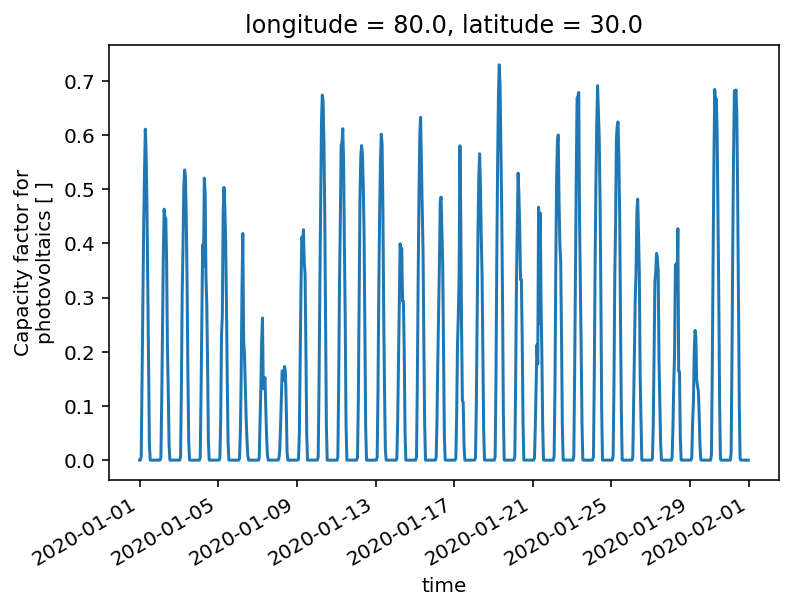

In [ ]:
lat = 30.0
lon = 80.0
solar_cf = ds['solarCF'].sel(latitude=lat, longitude=lon)

#Plot solarCF against time
solar_cf.plot()



Interpolated to nearest coordinate for solar_cf1: (30.25, 80.0)
Interpolated to nearest coordinate for solar_cf2: (53.0, 5.0)
Pearson's corr. coeff= -0.08398592204960405
pvalue= 0.021961821728672348


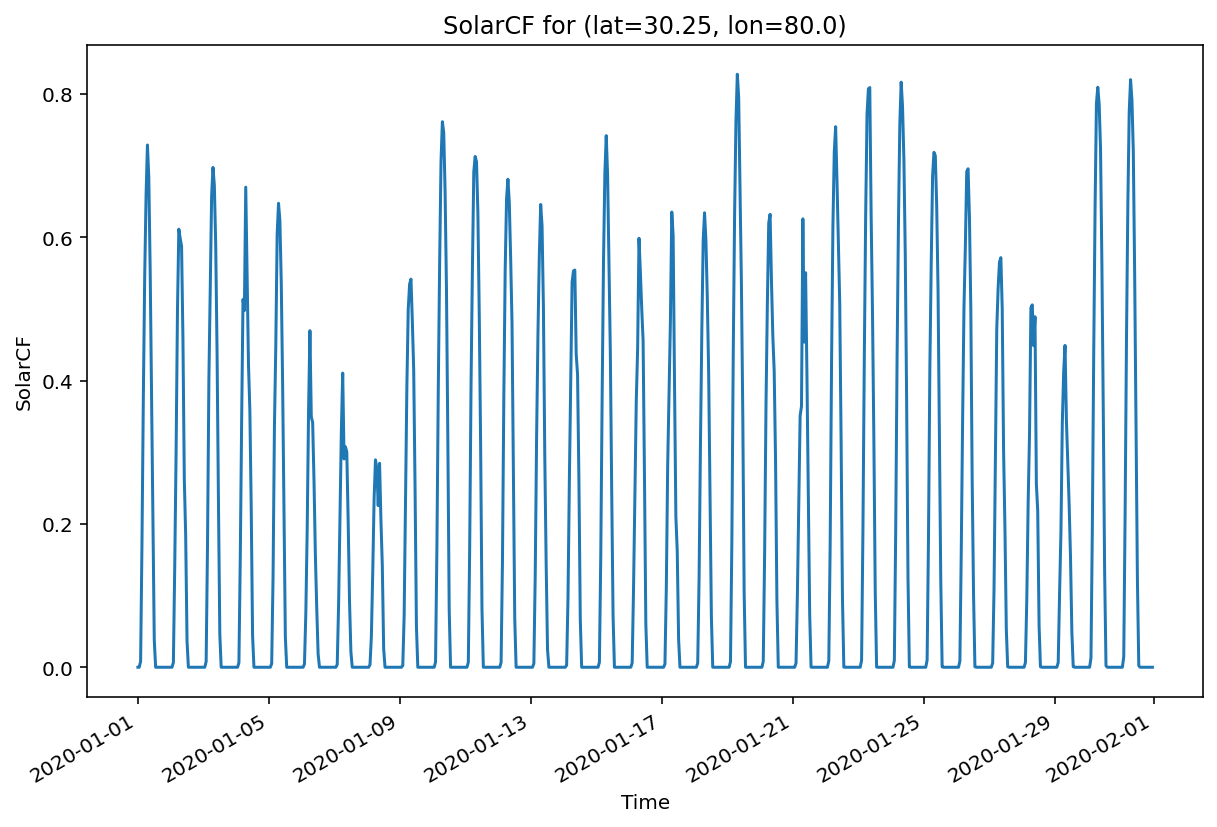

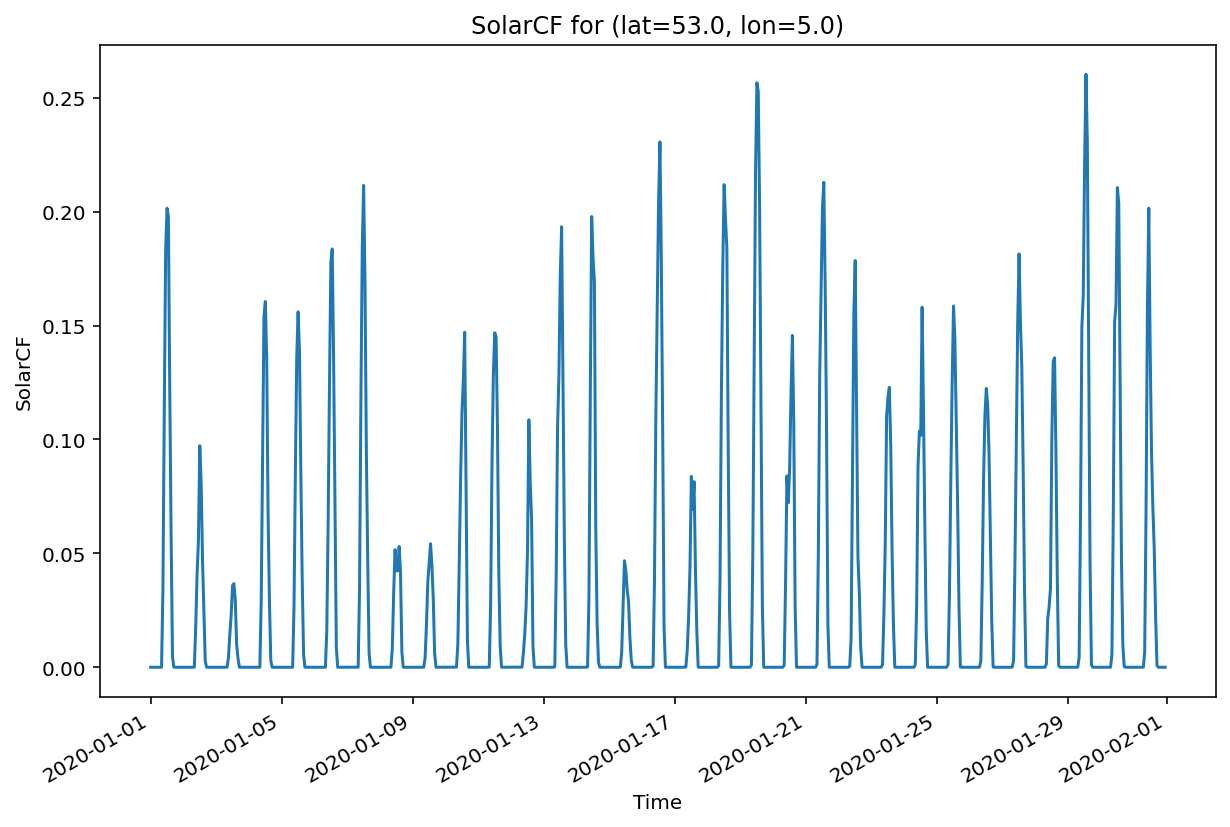

In [ ]:
lat1, lon1 = 30.3, 80.1
lat2, lon2 = 53.0, 5.0
solar_cf1 = ds['solarCF'].sel(latitude=lat1, longitude=lon1,method='nearest')
solar_cf2 = ds['solarCF'].sel(latitude=lat2, longitude=lon2,method='nearest')


#Replace lat and lon with actual (lat,lon) pairs present in the data after the 'nearest' method is used
actual_lat1 = ds['latitude'].sel(latitude=solar_cf1.latitude.values, method='nearest').values
actual_lon1 = ds['longitude'].sel(longitude=solar_cf1.longitude.values, method='nearest').values
print(f"Interpolated to nearest coordinate for solar_cf1: ({actual_lat1}, {actual_lon1})")
lat1, lon1 = actual_lat1, actual_lon1

solar_cf2 = ds['solarCF'].sel(latitude=lat2, longitude=lon2, method='nearest')
actual_lat2 = ds['latitude'].sel(latitude=solar_cf2.latitude.values, method='nearest').values
actual_lon2 = ds['longitude'].sel(longitude=solar_cf2.longitude.values, method='nearest').values
print(f"Interpolated to nearest coordinate for solar_cf2: ({actual_lat2}, {actual_lon2})")
lat2, lon2 = actual_lat2, actual_lon2

#Plot both time series separately
fig1, ax1 = plt.subplots(figsize=(10, 6))
solar_cf1.plot(ax=ax1)
ax1.set_title(f'SolarCF for (lat={lat1}, lon={lon1})')
ax1.set_xlabel('Time')
ax1.set_ylabel('SolarCF')

fig2, ax2 = plt.subplots(figsize=(10, 6))
solar_cf2.plot(ax=ax2)
ax2.set_title(f'SolarCF for (lat={lat2}, lon={lon2})')
ax2.set_xlabel('Time')
ax2.set_ylabel('SolarCF')


#find pearson's corr.
corr_coeff, p_value = stats.pearsonr(solar_cf1, solar_cf2)
print(f"Pearson's corr. coeff= {corr_coeff}")
print(f"pvalue= {p_value}")



In [ ]:
print((solar_cf1))

<xarray.DataArray 'solarCF' (time: 744)>
array([0.      , 0.      , 0.008156, ..., 0.      , 0.      , 0.      ],
      dtype=float32)
Coordinates:
    longitude  float32 80.0
    latitude   float32 30.25
  * time       (time) datetime64[ns] 2020-01-01 ... 2020-01-31T23:00:00
Attributes:
    units:         
    short_name:   solarCF
    long_name:    Capacity factor for photovoltaics
    method:       Based on Jerez et al., 2015
    description:  Hourly capacity factor of solar panels


always take 4 sample grid cells. if you have a given sample distance, 

In [ ]:
import geopy.distance


lat = lat2
lon = lon2
d = 50.0 #km

start_point = (lat2, lon2)
new_point = geopy.distance.distance(kilometers=d).destination(start_point, bearing=270) #straight down south

# Find the indices of the new point in the latitude and longitude dimensions
new_lat_idx = ds.latitude.sel(method='nearest', latitude=new_point.latitude).values
new_lon_idx = ds.longitude.sel(method='nearest', longitude=new_point.longitude).values

# Extract the climate data at the new location
solar_cf3 = ds['solarCF'].sel(latitude=new_lat_idx, longitude=new_lon_idx)
lat3 = ds['latitude'].sel(latitude=solar_cf3.latitude.values, method='nearest').values
lon3 = ds['longitude'].sel(longitude=solar_cf3.longitude.values, method='nearest').values

print(lat3,lon3)

53.0 4.25


Interpolated to nearest coordinate for solar_cf1: (52.5, 5.0)


Text(33.400000000000006, 0.5, 'SolarCF3')

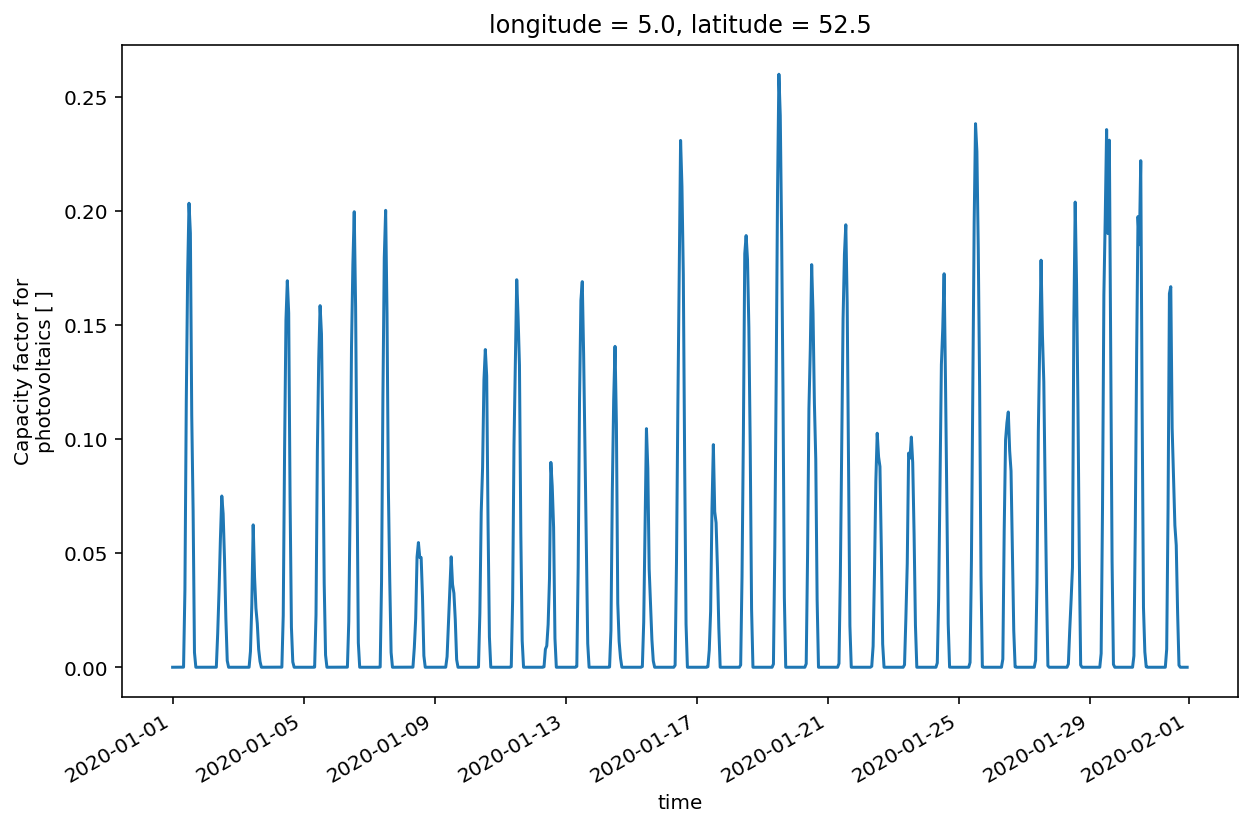

In [ ]:
solar_cf3 = ds['solarCF'].sel(latitude=lat3, longitude=lon3,method='nearest')


#Replace lat and lon with actual (lat,lon) pairs present in the data after the 'nearest' method is used
actual_lat3 = ds['latitude'].sel(latitude=solar_cf3.latitude.values, method='nearest').values
actual_lon3 = ds['longitude'].sel(longitude=solar_cf3.longitude.values, method='nearest').values
print(f"Interpolated to nearest coordinate for solar_cf1: ({actual_lat3}, {actual_lon3})")
lat1, lon1 = actual_lat3, actual_lon3

#Plot time series 
fig3, ax3 = plt.subplots(figsize=(10, 6))
solar_cf3.plot(ax=ax3)
ax1.set_title(f'SolarCF for (lat={lat3}, lon={lon3})')
ax1.set_xlabel('Time')
ax1.set_ylabel('SolarCF3')